<a href="https://colab.research.google.com/github/khaanca/UAS_PSM_Kelompok3/blob/knn/UAS_PSM_Kelompok6_KNearestNeighbor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import librosa
!pip install optuna
import optuna
import joblib
import os

from IPython import display

# feature engineering + selection
from glob import glob
from librosa import feature
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin

# modelling + evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

%matplotlib inline
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.2 MB/s eta 0:00:00


In [ ]:
# Download the Kaggle API from the Kaggle's account setting, then upload the kaggle.json file here
from google.colab import files
files.upload()

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

# Downloads the kaggle dataset, make sure enter the right dataset name and author
#format: author/name-name2-name3
!kaggle datasets download -d vbookshelf/respiratory-sound-database

!unzip respiratory-sound-database.zip -d respiratory_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vbookshelf/respiratory-sound-database
License(s): unknown
 99% 3.66G/3.69G [00:40<00:00, 232MB/s]
100% 3.69G/3.69G [00:41<00:00, 96.4MB/s]
Archive:  respiratory-sound-database.zip
  inflating: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_D

In [ ]:
for root, dirs, files in os.walk('respiratory_data'):
    print(f"Folder: {root}")
    for file in files:
        print(f"  - {file}")


Folder: respiratory_data
  - demographic_info.txt
Folder: respiratory_data/Respiratory_Sound_Database
Folder: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database
  - filename_format.txt
  - patient_diagnosis.csv
  - filename_differences.txt
Folder: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files
  - 156_2b3_Lr_mc_AKGC417L.wav
  - 130_2p5_Tc_mc_AKGC417L.wav
  - 160_1b3_Lr_mc_AKGC417L.wav
  - 186_2b4_Lr_mc_AKGC417L.txt
  - 175_1b1_Pr_sc_Litt3200.wav
  - 155_2b1_Al_mc_LittC2SE.txt
  - 111_1b2_Tc_sc_Meditron.txt
  - 158_1p2_Tc_mc_AKGC417L.wav
  - 205_2b4_Pl_mc_AKGC417L.wav
  - 130_1p3_Lr_mc_AKGC417L.wav
  - 151_3p2_Lr_mc_AKGC417L.txt
  - 197_1b1_Al_sc_Meditron.wav
  - 147_1b3_Tc_mc_AKGC417L.wav
  - 178_2b2_Pr_mc_AKGC417L.wav
  - 178_1b2_Ar_mc_AKGC417L.txt
  - 151_3p2_Pl_mc_AKGC417L.wav
  - 172_1b4_Al_mc_AKGC417L.txt
  - 174_1p2_Lr_mc_AKGC417L.txt
  - 186_2b2_Al_mc_AKGC417L.txt
  - 174_1p3_Ar_mc_AKGC417L.wav
  - 201_1b3_Ar_sc_Med

In [ ]:
base_audio_files = glob('respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/*.wav')
print(f"Found {len(base_audio_files)} files")

all_audio = {}

for audio_file in base_audio_files:
    # extract filename from path
    filename = audio_file.split('\\')[-1] # for Windows paths

    # load audio file
    y, sr = librosa.load(audio_file, mono=True)

    # store in dictionary
    all_audio[filename] = {
        'data': y,
        'sample_rate': sr
    }

print(f'Loaded {len(all_audio)} audio files')

Found 920 files
Loaded 920 audio files


In [ ]:
list(all_audio.keys())[:5]

['respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/156_2b3_Lr_mc_AKGC417L.wav',
 'respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/130_2p5_Tc_mc_AKGC417L.wav',
 'respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Lr_mc_AKGC417L.wav',
 'respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/175_1b1_Pr_sc_Litt3200.wav',
 'respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/158_1p2_Tc_mc_AKGC417L.wav']

# Data Preprocessing

Shortest audio file: respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/124_1b1_Pr_sc_Litt3200.wav
Duration: 7.86 seconds


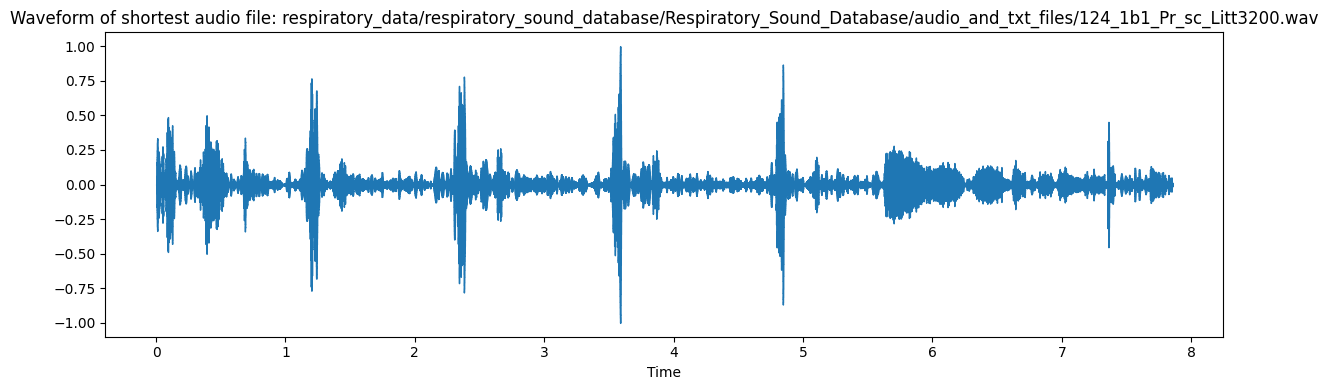

In [ ]:
# calculate duration for each audio file
for filename, audio_info in all_audio.items():
    duration = len(audio_info['data']) / audio_info['sample_rate']
    all_audio[filename]['duration'] = duration

# find the file with the minimum duration
min_duration_file = min(all_audio.items(), key=lambda x: x[1]['duration'])
min_filename = min_duration_file[0]
min_audio_info = min_duration_file[1]

print(f"Shortest audio file: {min_filename}")
print(f"Duration: {min_audio_info['duration']:.2f} seconds")

# plot the waveform of the shortest audio file
plt.figure(figsize=(12, 4))
librosa.display.waveshow(min_audio_info['data'], sr=min_audio_info['sample_rate'])
plt.title(f"Waveform of shortest audio file: {min_filename}")
plt.tight_layout()
plt.show()

display.Audio(data=min_audio_info['data'], rate=min_audio_info['sample_rate'])

In [ ]:
target_duration = min_audio_info['duration']
print(f"Duration of the shortest audio file: {target_duration} seconds")

trimmed_audio = {}

for filename, audio_info in all_audio.items():
    target_samples = int(target_duration * audio_info['sample_rate']) # calculate target samples
    trimmed_data = audio_info['data'][:target_samples] # trimmed to target duration

    # store in dictionary
    trimmed_audio[filename] = {
        'data': trimmed_data,
        'sample_rate': audio_info['sample_rate'],
        'duration': target_duration
    }

print(f'Trimmed all {len(trimmed_audio)} audio files to {target_duration} seconds')

Duration of the shortest audio file: 7.8560090702947845 seconds
Trimmed all 920 audio files to 7.8560090702947845 seconds


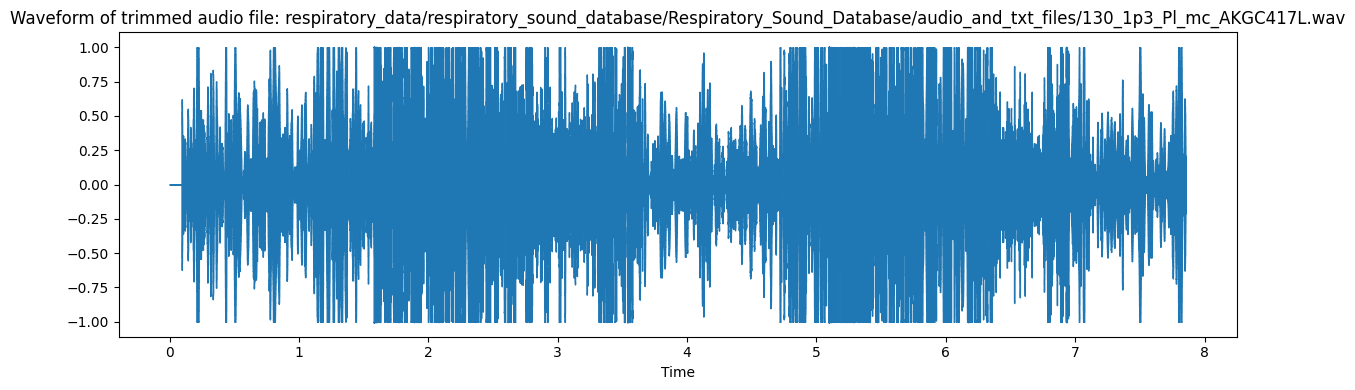

In [ ]:
# plot the waveform of a sample trimmed audio file
sample_file = list(trimmed_audio.keys())[90]
plt.figure(figsize=(12, 4))
librosa.display.waveshow(trimmed_audio[sample_file]['data'], sr=trimmed_audio[sample_file]['sample_rate'])
plt.title(f"Waveform of trimmed audio file: {sample_file}")
plt.tight_layout()
plt.show()

# Feature Extraction

In [ ]:
fn_list = [
    feature.chroma_stft,       # Chromagram from STFT
    feature.mfcc,              # Mel-frequency cepstral coefficients
    feature.melspectrogram,    # Mel-scaled spectrogram
    feature.spectral_contrast, # Spectral contrast
    feature.tonnetz,           # Tonal centroid features
    feature.rms,               # Root-mean-square energy
    feature.zero_crossing_rate,# Zero crossing rate
    feature.spectral_bandwidth,# Spectral bandwidth
    feature.spectral_centroid, # Spectral centroid
    feature.spectral_flatness, # Spectral flatness
    feature.spectral_rolloff,  # Spectral roll-off
    feature.poly_features,     # Polynomial features
    feature.tempogram          # Tempogram
]

audio_features = {}

# extract features for each audio file
for filename, audio_info in trimmed_audio.items():
    y = audio_info['data']
    sr = audio_info['sample_rate']

    audio_features[filename] = {}

    audio_features[filename]['chroma_stft'] = feature.chroma_stft(y=y, sr=sr)
    audio_features[filename]['mfcc'] = feature.mfcc(y=y, sr=sr, n_mfcc=13)
    audio_features[filename]['mel_spectrogram'] = feature.melspectrogram(y=y, sr=sr)
    audio_features[filename]['spectral_contrast'] = feature.spectral_contrast(y=y, sr=sr)
    audio_features[filename]['spectral_centroid'] = feature.spectral_centroid(y=y, sr=sr)
    audio_features[filename]['spectral_bandwidth'] = feature.spectral_bandwidth(y=y, sr=sr)
    audio_features[filename]['spectral_rolloff'] = feature.spectral_rolloff(y=y, sr=sr)
    audio_features[filename]['zero_crossing_rate'] = feature.zero_crossing_rate(y=y)

In [ ]:
# display feature shape for first file
sample_file = list(audio_features.keys())[0]
for feature_name, feature_data in audio_features[sample_file].items():
    print(f"{feature_name}: {feature_data.shape}")

chroma_stft: (12, 339)
mfcc: (13, 339)
mel_spectrogram: (128, 339)
spectral_contrast: (7, 339)
spectral_centroid: (1, 339)
spectral_bandwidth: (1, 339)
spectral_rolloff: (1, 339)
zero_crossing_rate: (1, 339)


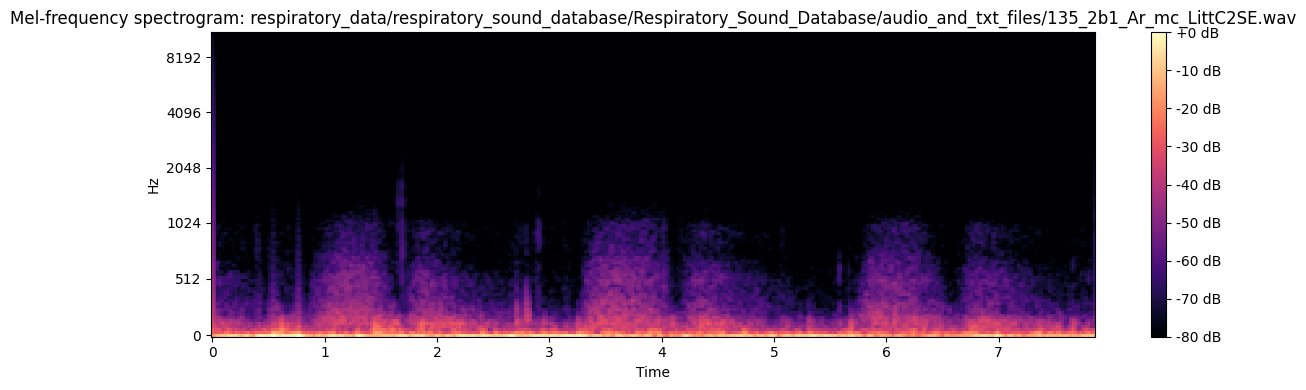

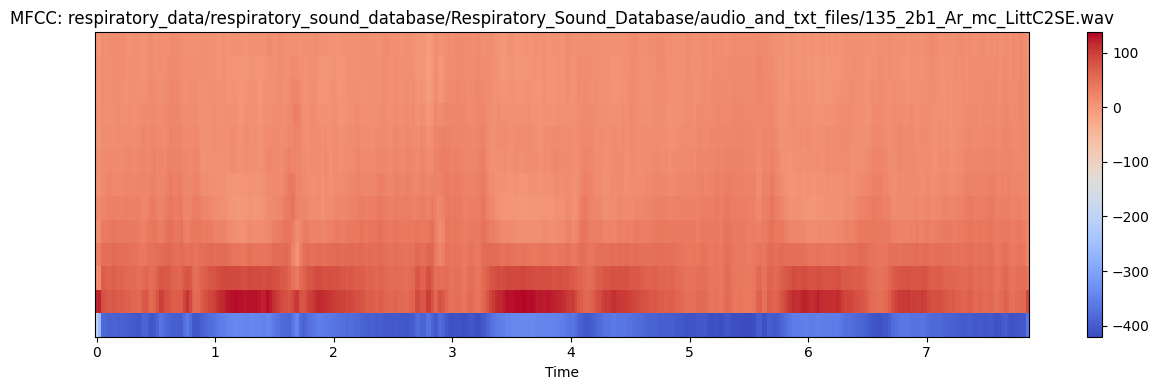

In [ ]:
# sample file to visualize
sample_file = list(audio_features.keys())[0]
sample_data = trimmed_audio[sample_file]['data']
sample_sr = trimmed_audio[sample_file]['sample_rate']

# plot mel spectrogram
plt.figure(figsize=(12, 4))
S = librosa.feature.melspectrogram(y=sample_data, sr=sample_sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sample_sr)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-frequency spectrogram: {sample_file}')
plt.tight_layout()
plt.show()

# plot mfccs
plt.figure(figsize=(12, 4))
mfccs = librosa.feature.mfcc(y=sample_data, sr=sample_sr, n_mfcc=13)
librosa.display.specshow(mfccs, x_axis='time', sr=sample_sr)
plt.colorbar()
plt.title(f'MFCC: {sample_file}')
plt.tight_layout()
plt.show()

In [ ]:
feature_stats = []

for filename, features in audio_features.items():
    file_stats = {'filename': filename}

    # calculate statistics for each feature
    for feature_name, feature_data in features.items():
        file_stats[f'{feature_name}_mean'] = np.mean(feature_data)
        file_stats[f'{feature_name}_std'] = np.std(feature_data)
        file_stats[f'{feature_name}_max'] = np.max(feature_data)
        file_stats[f'{feature_name}_min'] = np.min(feature_data)

    feature_stats.append(file_stats)

# create dataframe
df = pd.DataFrame(feature_stats)
df.head()

,filename,chroma_stft_mean,chroma_stft_std,chroma_stft_max,chroma_stft_min,mfcc_mean,mfcc_std,mfcc_max,mfcc_min,mel_spectrogram_mean,...,spectral_bandwidth_max,spectral_bandwidth_min,spectral_rolloff_mean,spectral_rolloff_std,spectral_rolloff_max,spectral_rolloff_min,zero_crossing_rate_mean,zero_crossing_rate_std,zero_crossing_rate_max,zero_crossing_rate_min
0,respiratory_data/respiratory_sound_database/Re...,0.809720,0.154945,1.0,0.290788,-2.144818,112.632370,137.251282,-420.335266,11.028161,...,2194.788384,283.095421,91.881352,194.716246,2928.515625,21.533203,0.001352,0.001102,0.007812,0.000488
1,respiratory_data/respiratory_sound_database/Re...,0.792714,0.168878,1.0,0.184380,-5.996775,120.710609,182.743835,-469.905029,2.743027,...,2419.816872,391.345737,150.478343,264.224101,2993.115234,21.533203,0.001798,0.001329,0.009766,0.000000
2,respiratory_data/respiratory_sound_database/Re...,0.703565,0.220346,1.0,0.093533,-14.882191,157.105255,217.247375,-609.050781,0.060120,...,2118.497765,484.675497,471.824876,251.008762,1173.559570,86.132812,0.008171,0.003415,0.020508,0.002441
3,respiratory_data/respiratory_sound_database/Re...,0.648110,0.268602,1.0,0.000000,6.986827,73.997414,199.914246,-461.216766,14.324510,...,2552.765806,0.000000,1284.147496,966.683683,10766.601562,0.000000,0.011369,0.012559,0.118652,0.000000
4,respiratory_data/respiratory_sound_database/Re...,0.640140,0.284692,1.0,0.013180,-7.788445,140.659134,159.778503,-515.589355,0.664953,...,2221.014342,299.922258,128.405222,117.711721,2056.420898,21.533203,0.003856,0.002699,0.011719,0.000488


In [ ]:
# read patient diagnosis data
patient_diagnosis = pd.read_csv('respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', header=None)
patient_diagnosis.columns = ['patient_id', 'diagnosis']

patient_diagnosis.head()

,patient_id,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
df['filename'] = df['filename'].str.replace('respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/', '', regex=False)

df.head()

,filename,chroma_stft_mean,chroma_stft_std,chroma_stft_max,chroma_stft_min,mfcc_mean,mfcc_std,mfcc_max,mfcc_min,mel_spectrogram_mean,...,spectral_bandwidth_max,spectral_bandwidth_min,spectral_rolloff_mean,spectral_rolloff_std,spectral_rolloff_max,spectral_rolloff_min,zero_crossing_rate_mean,zero_crossing_rate_std,zero_crossing_rate_max,zero_crossing_rate_min
0,135_2b1_Ar_mc_LittC2SE.wav,0.809720,0.154945,1.0,0.290788,-2.144818,112.632370,137.251282,-420.335266,11.028161,...,2194.788384,283.095421,91.881352,194.716246,2928.515625,21.533203,0.001352,0.001102,0.007812,0.000488
1,140_2b3_Tc_mc_LittC2SE.wav,0.792714,0.168878,1.0,0.184380,-5.996775,120.710609,182.743835,-469.905029,2.743027,...,2419.816872,391.345737,150.478343,264.224101,2993.115234,21.533203,0.001798,0.001329,0.009766,0.000000
2,201_1b3_Al_sc_Meditron.wav,0.703565,0.220346,1.0,0.093533,-14.882191,157.105255,217.247375,-609.050781,0.060120,...,2118.497765,484.675497,471.824876,251.008762,1173.559570,86.132812,0.008171,0.003415,0.020508,0.002441
3,151_3p3_Ll_mc_AKGC417L.wav,0.648110,0.268602,1.0,0.000000,6.986827,73.997414,199.914246,-461.216766,14.324510,...,2552.765806,0.000000,1284.147496,966.683683,10766.601562,0.000000,0.011369,0.012559,0.118652,0.000000
4,192_2b1_Ar_mc_LittC2SE.wav,0.640140,0.284692,1.0,0.013180,-7.788445,140.659134,159.778503,-515.589355,0.664953,...,2221.014342,299.922258,128.405222,117.711721,2056.420898,21.533203,0.003856,0.002699,0.011719,0.000488


In [ ]:
# map the diagnosis to the dataframe based on the patient ID extracted from the filename
df['diagnosis'] = df['filename'].apply(
	lambda x: patient_diagnosis.loc[
		patient_diagnosis['patient_id'] == int(x.split('_')[0]), 'diagnosis'
	].values[0] if int(x.split('_')[0]) in patient_diagnosis['patient_id'].values else None
)

df

,filename,chroma_stft_mean,chroma_stft_std,chroma_stft_max,chroma_stft_min,mfcc_mean,mfcc_std,mfcc_max,mfcc_min,mel_spectrogram_mean,...,spectral_bandwidth_min,spectral_rolloff_mean,spectral_rolloff_std,spectral_rolloff_max,spectral_rolloff_min,zero_crossing_rate_mean,zero_crossing_rate_std,zero_crossing_rate_max,zero_crossing_rate_min,diagnosis
0,135_2b1_Ar_mc_LittC2SE.wav,0.809720,0.154945,1.0,0.290788,-2.144818,112.632370,137.251282,-420.335266,11.028161,...,283.095421,91.881352,194.716246,2928.515625,21.533203,0.001352,0.001102,0.007812,0.000488,Pneumonia
1,140_2b3_Tc_mc_LittC2SE.wav,0.792714,0.168878,1.0,0.184380,-5.996775,120.710609,182.743835,-469.905029,2.743027,...,391.345737,150.478343,264.224101,2993.115234,21.533203,0.001798,0.001329,0.009766,0.000000,Pneumonia
2,201_1b3_Al_sc_Meditron.wav,0.703565,0.220346,1.0,0.093533,-14.882191,157.105255,217.247375,-609.050781,0.060120,...,484.675497,471.824876,251.008762,1173.559570,86.132812,0.008171,0.003415,0.020508,0.002441,Bronchiectasis
3,151_3p3_Ll_mc_AKGC417L.wav,0.648110,0.268602,1.0,0.000000,6.986827,73.997414,199.914246,-461.216766,14.324510,...,0.000000,1284.147496,966.683683,10766.601562,0.000000,0.011369,0.012559,0.118652,0.000000,COPD
4,192_2b1_Ar_mc_LittC2SE.wav,0.640140,0.284692,1.0,0.013180,-7.788445,140.659134,159.778503,-515.589355,0.664953,...,299.922258,128.405222,117.711721,2056.420898,21.533203,0.003856,0.002699,0.011719,0.000488,COPD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,135_2b3_Ar_mc_LittC2SE.wav,0.803365,0.156908,1.0,0.299625,-6.081966,130.360931,152.469345,-492.506866,2.869717,...,346.897984,111.858321,216.818505,3057.714844,21.533203,0.001449,0.000989,0.007324,0.000488,Pneumonia
916,172_1b4_Pr_mc_AKGC417L.wav,0.623788,0.265923,1.0,0.000000,0.124158,101.719467,223.574112,-461.214630,9.804689,...,0.000000,551.796270,731.406406,10766.601562,0.000000,0.012361,0.011014,0.092285,0.000000,COPD
917,211_1p5_Ar_mc_AKGC417L.wav,0.751980,0.191473,1.0,0.000000,0.430304,106.502480,181.579132,-479.506958,8.724417,...,0.000000,279.614042,627.771856,10766.601562,0.000000,0.005856,0.009435,0.088379,0.000000,COPD
918,176_2b3_Ll_mc_AKGC417L.wav,0.734454,0.195794,1.0,0.000000,-3.637045,95.301353,149.842499,-613.267273,0.755502,...,0.000000,2097.232353,1230.338829,10755.834961,0.000000,0.012773,0.012081,0.094727,0.000000,COPD


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 920 non-null    object 
 1   chroma_stft_mean         920 non-null    float32
 2   chroma_stft_std          920 non-null    float32
 3   chroma_stft_max          920 non-null    float32
 4   chroma_stft_min          920 non-null    float32
 5   mfcc_mean                920 non-null    float32
 6   mfcc_std                 920 non-null    float32
 7   mfcc_max                 920 non-null    float32
 8   mfcc_min                 920 non-null    float32
 9   mel_spectrogram_mean     920 non-null    float32
 10  mel_spectrogram_std      920 non-null    float32
 11  mel_spectrogram_max      920 non-null    float32
 12  mel_spectrogram_min      920 non-null    float32
 13  spectral_contrast_mean   920 non-null    float64
 14  spectral_contrast_std    9

In [ ]:
print(f"Missing values: {df.isna().sum().sum()}")
print(f"Duplicated rows: {df.duplicated().sum()}")

Missing values: 0
Duplicated rows: 0


# Exploratory Data Analysis

Target value counts: diagnosis
3    793
6     37
4     35
7     23
1     16
2     13
5      2
0      1
Name: count, dtype: int64


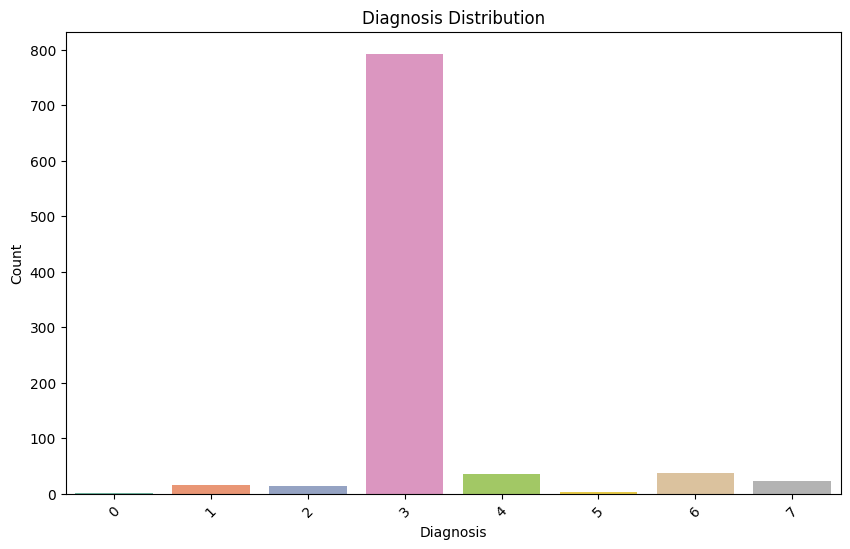

In [ ]:
df_2 = df.copy()

le = LabelEncoder()

df_2['diagnosis'] = le.fit_transform(df_2['diagnosis'])

print(f"Target value counts: {df_2['diagnosis'].value_counts()}")

# plot target proportion using bar plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_2, x='diagnosis', palette='Set2')
plt.title('Diagnosis Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

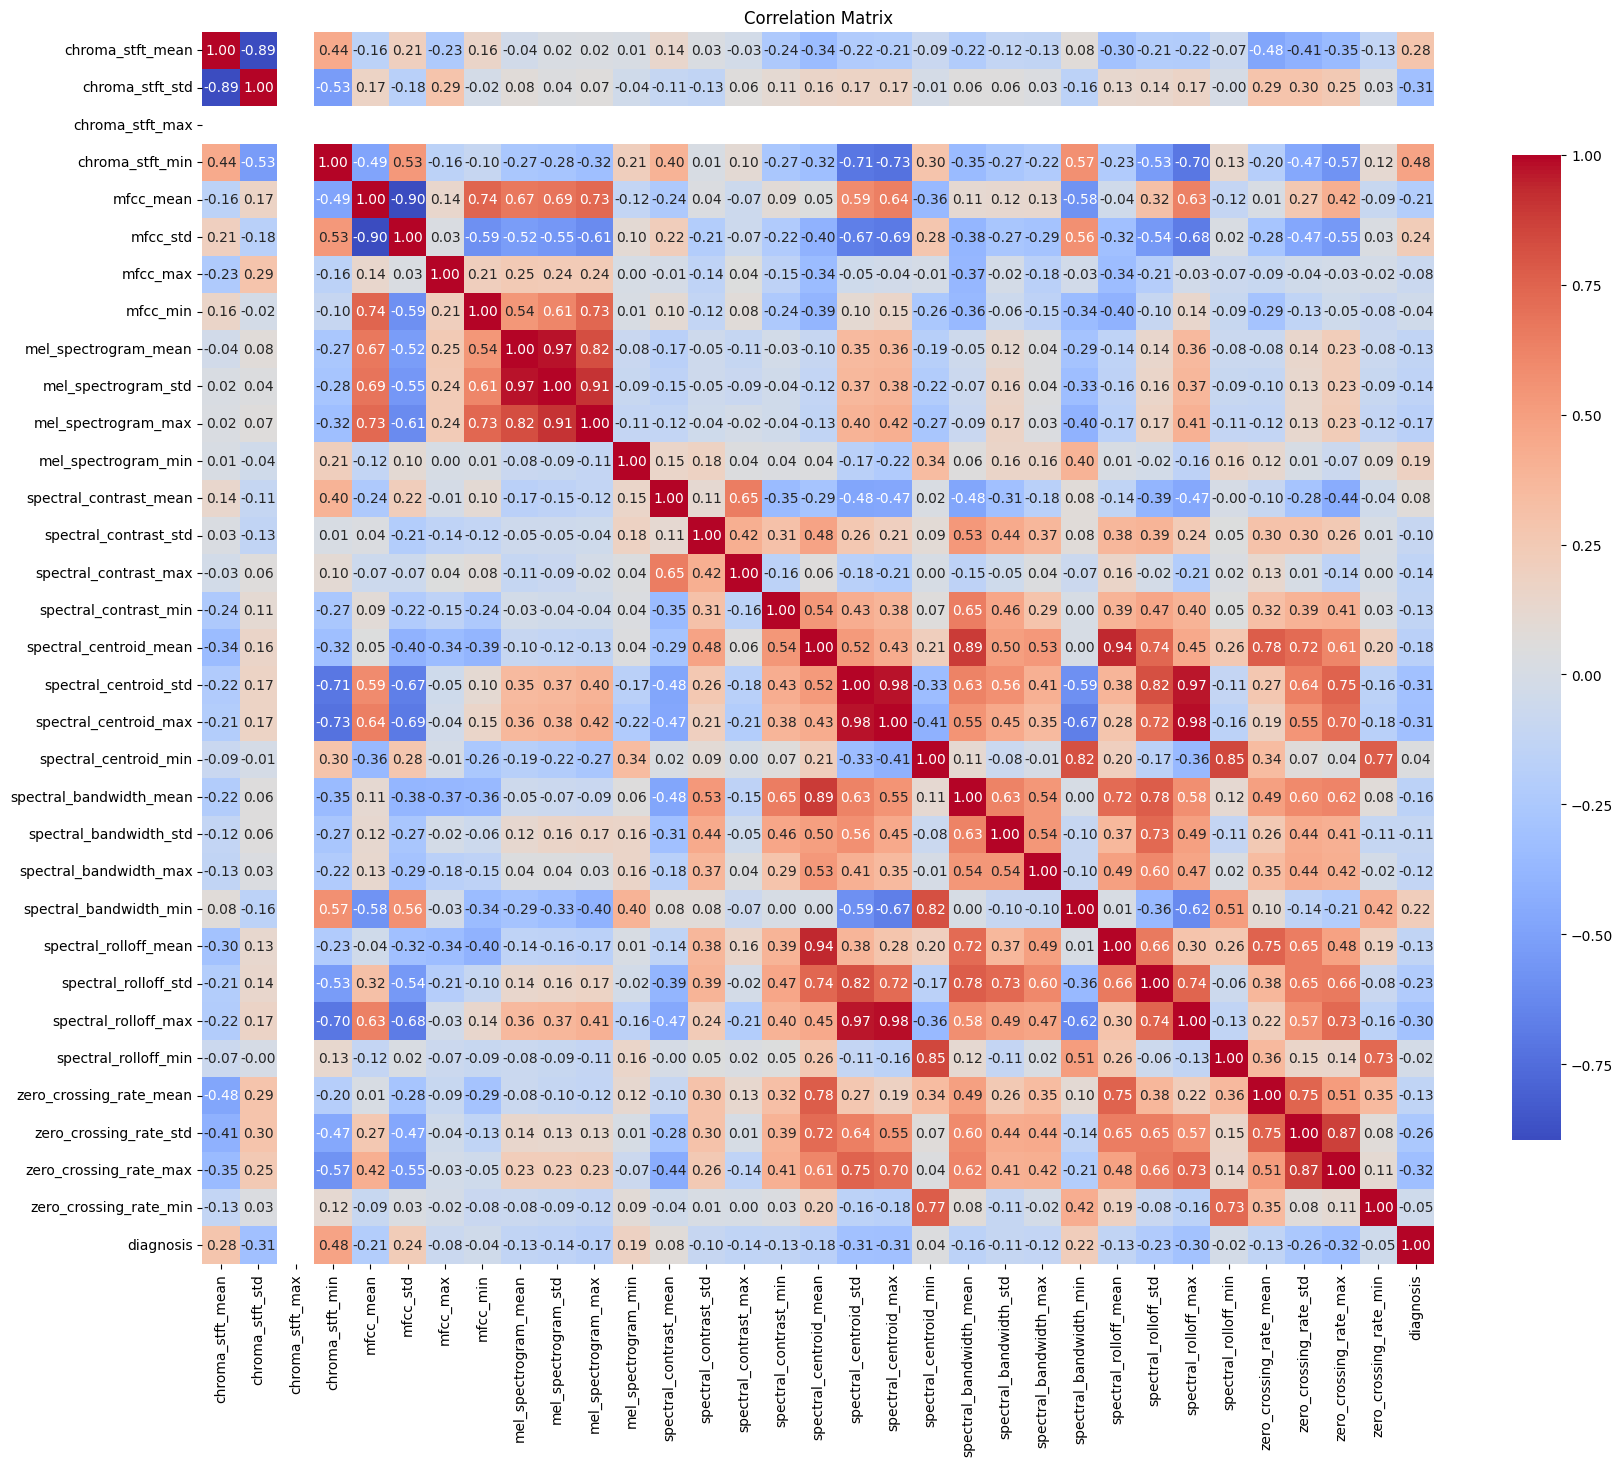

In [ ]:
df_2 = df_2.drop(['filename'], axis=1)

corr_mat = df_2.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

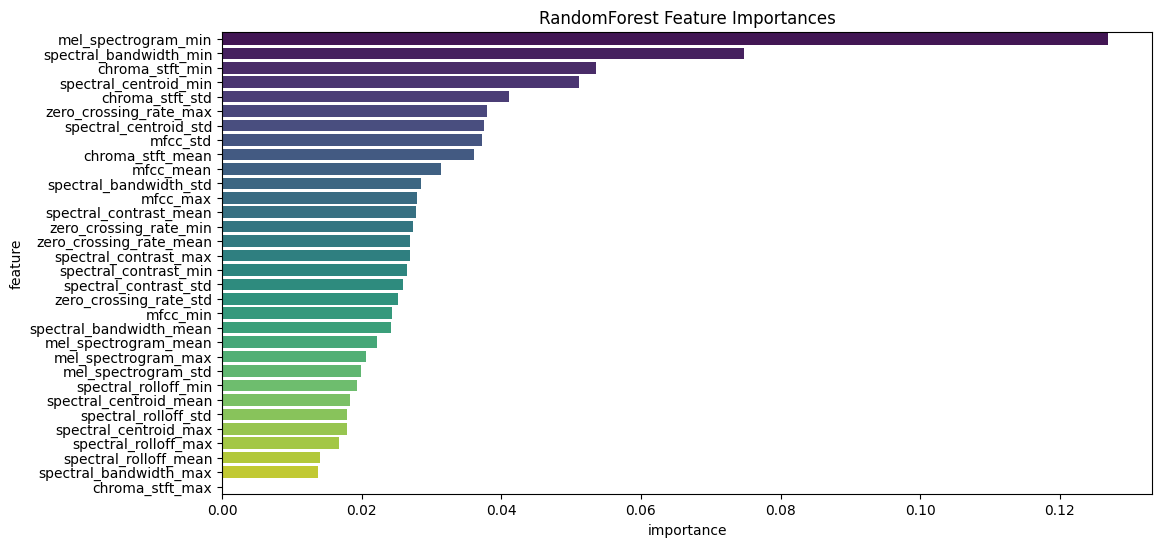

In [ ]:
X = df.select_dtypes(exclude=['object'])
y = df['diagnosis'].values

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('RandomForest Feature Importances')
plt.show()

In [ ]:
excluded_features = ['mel_spectrogram_min', 'chroma_stft_max']

X = X.drop(excluded_features, axis=1)

X.columns

Index(['chroma_stft_mean', 'chroma_stft_std', 'chroma_stft_min', 'mfcc_mean',
       'mfcc_std', 'mfcc_max', 'mfcc_min', 'mel_spectrogram_mean',
       'mel_spectrogram_std', 'mel_spectrogram_max', 'spectral_contrast_mean',
       'spectral_contrast_std', 'spectral_contrast_max',
       'spectral_contrast_min', 'spectral_centroid_mean',
       'spectral_centroid_std', 'spectral_centroid_max',
       'spectral_centroid_min', 'spectral_bandwidth_mean',
       'spectral_bandwidth_std', 'spectral_bandwidth_max',
       'spectral_bandwidth_min', 'spectral_rolloff_mean',
       'spectral_rolloff_std', 'spectral_rolloff_max', 'spectral_rolloff_min',
       'zero_crossing_rate_mean', 'zero_crossing_rate_std',
       'zero_crossing_rate_max', 'zero_crossing_rate_min'],
      dtype='object')

In [ ]:
pd.Series(y).value_counts()

,count
COPD,793
Pneumonia,37
Healthy,35
URTI,23
Bronchiectasis,16
Bronchiolitis,13
LRTI,2
Asthma,1


# Modelling and Evaluation

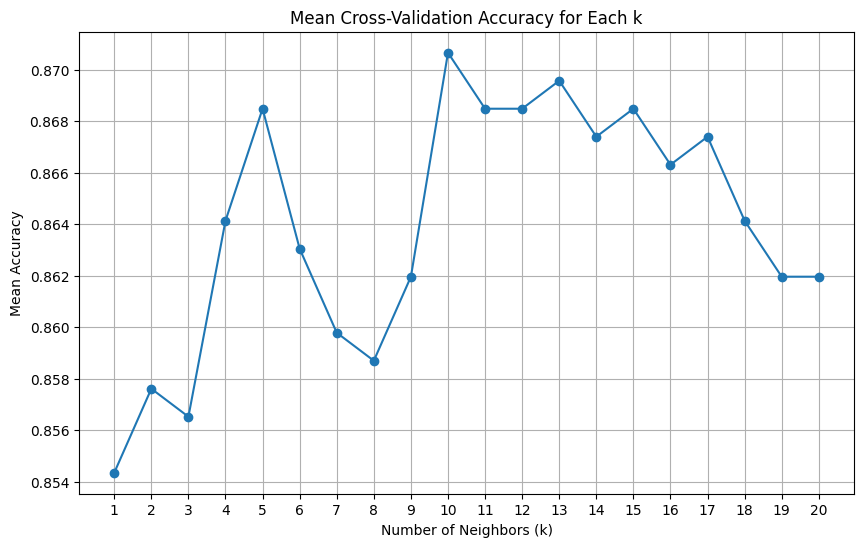

Best k: 10 with mean accuracy: 0.8707

Fold 1:
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.00      0.00      0.00         3
 Bronchiolitis       0.00      0.00      0.00         2
          COPD       0.90      0.98      0.94       159
       Healthy       0.25      0.14      0.18         7
     Pneumonia       0.50      0.25      0.33         8
          URTI       0.00      0.00      0.00         5

      accuracy                           0.86       184
     macro avg       0.28      0.23      0.24       184
  weighted avg       0.81      0.86      0.83       184



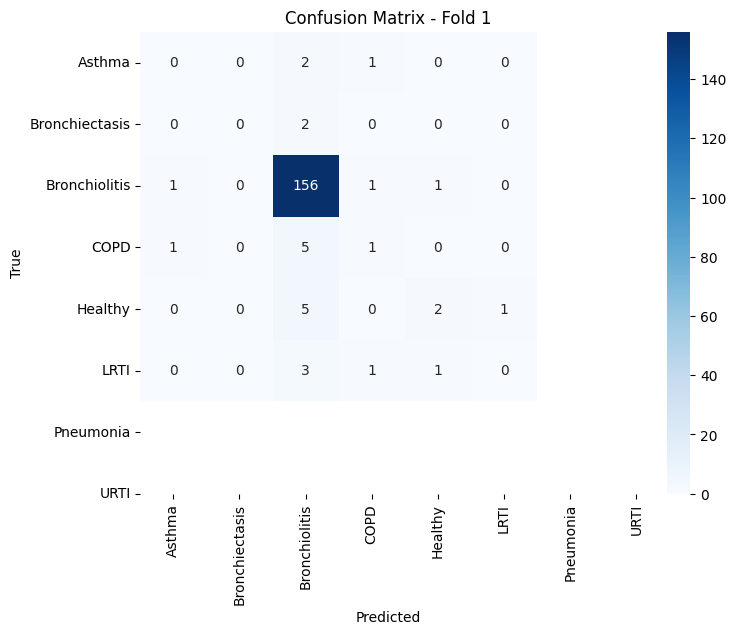


Fold 2:
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       1.00      0.33      0.50         3
 Bronchiolitis       0.00      0.00      0.00         3
          COPD       0.93      0.97      0.95       158
       Healthy       0.33      0.43      0.38         7
     Pneumonia       0.43      0.38      0.40         8
          URTI       0.50      0.20      0.29         5

      accuracy                           0.88       184
     macro avg       0.53      0.39      0.42       184
  weighted avg       0.86      0.88      0.87       184



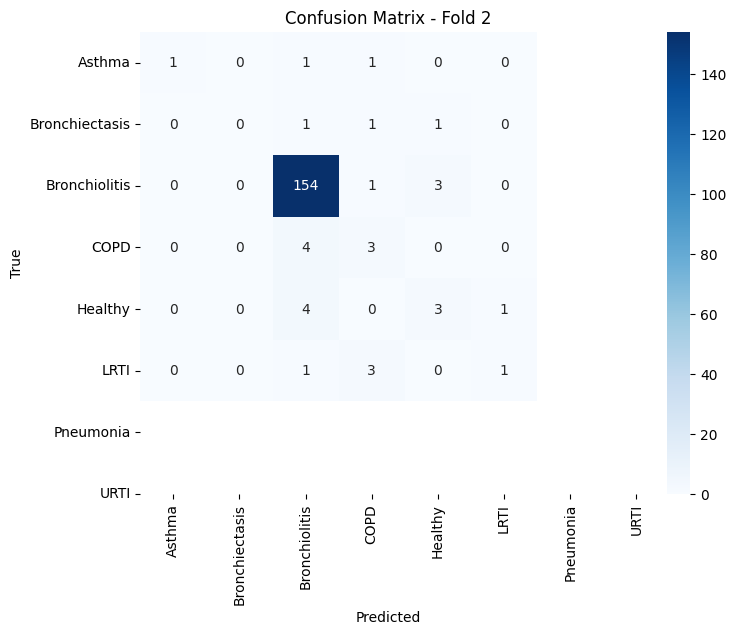


Fold 3:
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.50      0.25      0.33         4
 Bronchiolitis       0.00      0.00      0.00         3
          COPD       0.92      0.99      0.95       158
       Healthy       0.50      0.29      0.36         7
          LRTI       0.00      0.00      0.00         1
     Pneumonia       0.33      0.29      0.31         7
          URTI       0.50      0.25      0.33         4

      accuracy                           0.88       184
     macro avg       0.39      0.29      0.33       184
  weighted avg       0.85      0.88      0.86       184



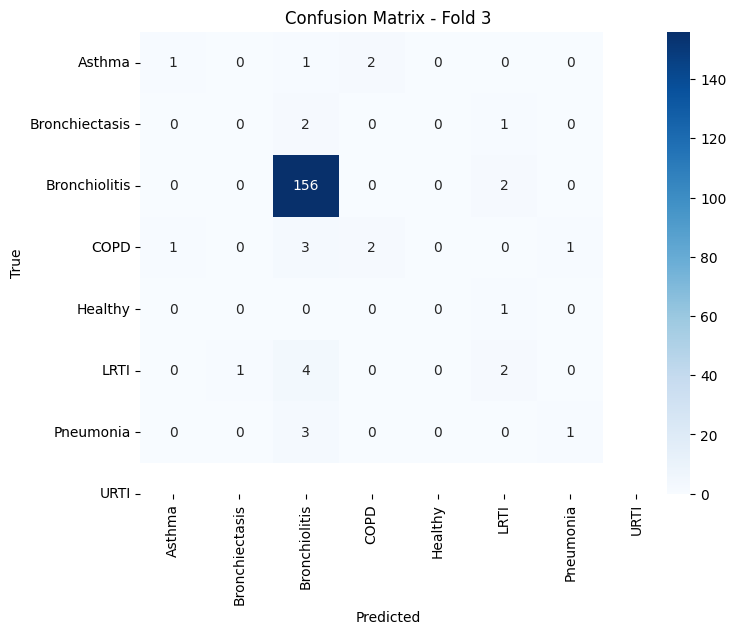


Fold 4:
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       1.00      0.33      0.50         3
 Bronchiolitis       0.00      0.00      0.00         3
          COPD       0.92      0.97      0.95       159
       Healthy       0.57      0.57      0.57         7
          LRTI       0.00      0.00      0.00         1
     Pneumonia       0.20      0.14      0.17         7
          URTI       0.00      0.00      0.00         4

      accuracy                           0.88       184
     macro avg       0.38      0.29      0.31       184
  weighted avg       0.84      0.88      0.86       184



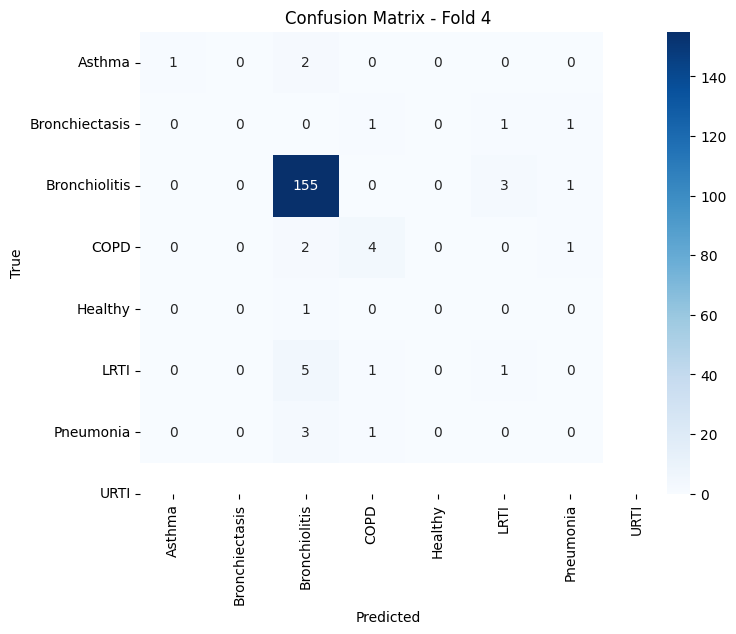


Fold 5:
Classification Report:
                precision    recall  f1-score   support

        Asthma       0.00      0.00      0.00         1
Bronchiectasis       0.33      0.33      0.33         3
 Bronchiolitis       0.00      0.00      0.00         2
          COPD       0.90      0.97      0.93       159
       Healthy       0.25      0.14      0.18         7
     Pneumonia       0.25      0.14      0.18         7
          URTI       0.00      0.00      0.00         5

      accuracy                           0.85       184
     macro avg       0.25      0.23      0.23       184
  weighted avg       0.80      0.85      0.83       184



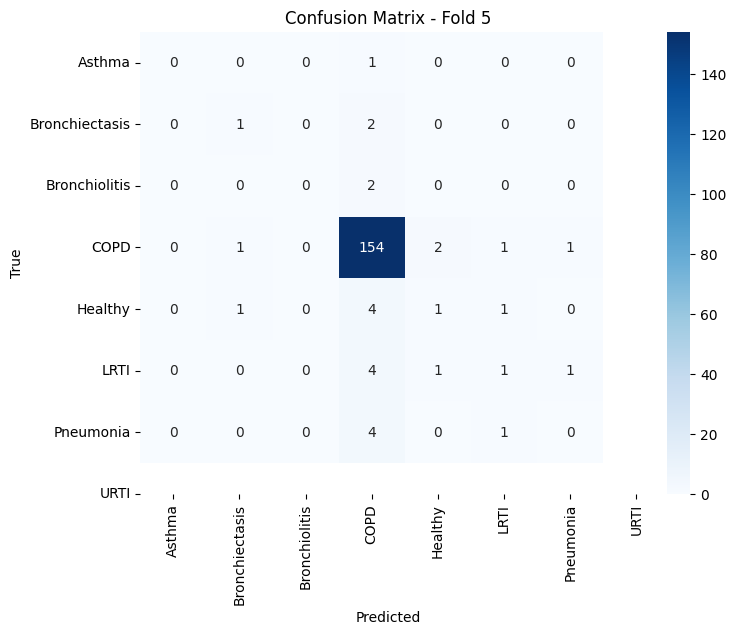


Mean F1 Score: 0.8481
Mean Accuracy Score: 0.8707


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# Try different k values
k_values = range(1, 21)
accuracies_per_k = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies_per_k.append(acc)

# Plotting accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies_per_k, marker='o')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Best k
best_k = k_values[np.argmax(accuracies_per_k)]
print(f"Best k: {best_k} with accuracy: {max(accuracies_per_k):.4f}")

# Final model evaluation with best k
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"\nF1 Score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import librosa
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier  # ✅ switched from RandomForest
from sklearn.model_selection import cross_val_score

# --- Custom Transformers ---

class AudioLoader(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = {}
        for file_path in X:
            filename = file_path.split('\\')[-1] if '\\' in file_path else file_path.split('/')[-1]
            y, sr = librosa.load(file_path, mono=True)
            result[filename] = {'data': y, 'sample_rate': sr}
        return result

class AudioTrimmer(BaseEstimator, TransformerMixin):
    def __init__(self, target_duration=7.8560090702947845):
        self.target_duration = target_duration

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        trimmed = {}
        for filename, audio_info in X.items():
            target_samples = int(self.target_duration * audio_info['sample_rate'])
            if len(audio_info['data']) < target_samples:
                trimmed_data = np.pad(audio_info['data'], (0, target_samples - len(audio_info['data'])), 'constant')
            else:
                trimmed_data = audio_info['data'][:target_samples]
            trimmed[filename] = {
                'data': trimmed_data,
                'sample_rate': audio_info['sample_rate'],
                'duration': self.target_duration
            }
        return trimmed

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = {}
        for filename, audio_info in X.items():
            y_audio = audio_info['data']
            sr = audio_info['sample_rate']
            features[filename] = {
                'chroma_stft': librosa.feature.chroma_stft(y=y_audio, sr=sr),
                'mfcc': librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=13),
                'mel_spectrogram': librosa.feature.melspectrogram(y=y_audio, sr=sr),
                'spectral_contrast': librosa.feature.spectral_contrast(y=y_audio, sr=sr),
                'spectral_centroid': librosa.feature.spectral_centroid(y=y_audio, sr=sr),
                'spectral_bandwidth': librosa.feature.spectral_bandwidth(y=y_audio, sr=sr),
                'spectral_rolloff': librosa.feature.spectral_rolloff(y=y_audio, sr=sr),
                'zero_crossing_rate': librosa.feature.zero_crossing_rate(y=y_audio),
            }
        return features

class FeatureStatisticsCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, excluded_features=None):
        self.excluded_features = excluded_features or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        feature_stats = []
        for filename, features in X.items():
            file_stats = {'filename': filename}
            for feature_name, feature_data in features.items():
                file_stats[f'{feature_name}_mean'] = np.mean(feature_data)
                file_stats[f'{feature_name}_std'] = np.std(feature_data)
                file_stats[f'{feature_name}_max'] = np.max(feature_data)
                file_stats[f'{feature_name}_min'] = np.min(feature_data)
            feature_stats.append(file_stats)
        df = pd.DataFrame(feature_stats)
        for feature in self.excluded_features:
            if feature in df.columns:
                df = df.drop(feature, axis=1)
        return df.select_dtypes(exclude=['object'])

# --- KNN Model Saving Function ---

def save_model(model, filename='respiratory_classifier_knn.pkl'):
    """Save the trained model"""
    joblib.dump(model, filename)
    print(f"KNN model saved as {filename}")

# --- Pipeline Creator ---

def create_respiratory_pipeline():
    """Create a pipeline for respiratory sound classification"""
    excluded_features = ['mel_spectrogram_min', 'chroma_stft_max']
    preprocessing_pipeline = Pipeline([
        ('load_audio', AudioLoader()),
        ('trim_audio', AudioTrimmer(target_duration=7.8560090702947845)),
        ('extract_features', FeatureExtractor()),
        ('calculate_statistics', FeatureStatisticsCalculator(excluded_features=excluded_features))
    ])
    return preprocessing_pipeline

# --- Training Function ---

def train_knn_model(X_train, y_train, k=5, model_path='respiratory_classifier_knn.pkl'):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    save_model(model, model_path)

# --- Prediction Function ---

def predict_respiratory_condition_knn(wav_file_path, model_path='respiratory_classifier_knn.pkl'):
    """Predict respiratory condition from a WAV file using a saved KNN model"""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found")

    model = joblib.load(model_path)
    preprocessing_pipeline = create_respiratory_pipeline()
    features_df = preprocessing_pipeline.transform([wav_file_path])

    prediction = model.predict(features_df)[0]
    probabilities = model.predict_proba(features_df)[0]

    max_prob = np.max(probabilities)
    classes = model.classes_

    return {
        'prediction': prediction,
        'probability': max_prob,
        'all_probabilities': dict(zip(classes, probabilities))
    }

In [ ]:
save_model(rf_optimized)

Model saved as respiratory_classifier.pkl


# Testing

In [ ]:
df[['filename','diagnosis']].sample()

,filename,diagnosis
883,152_1b1_Al_sc_Meditron.wav,Healthy


In [ ]:
# pipeline usage
result = predict_respiratory_condition('respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/152_1b1_Al_sc_Meditron.wav',
                                       model_path='respiratory_classifier.pkl')
print(f"Predicted condition: {result['prediction']} (confidence: {result['probability']:.2f})")

Predicted condition: Healthy (confidence: 0.57)
